### Setting Up the Environment for TensorFlow and ONNX Integration in Google Colab

**Description:**  
This script sets up the necessary environment in Google Colab for working with TensorFlow and ONNX, enabling smooth integration and model conversion. The key steps include:

1. **Mounting Google Drive**: Provides access to data and files stored on Google Drive.
2. **Installing TensorFlow**: Installs TensorFlow version `2.13.0` for compatibility with the desired ONNX workflows.
3. **Installing TensorFlow Probability**: Adds support for probabilistic modeling using `tensorflow-probability` version `0.20.0`.
4. **Installing ONNX and ONNX-TensorFlow**:
   - The `onnx-tf` library bridges ONNX and TensorFlow for model interoperability.
   - The `onnx` library is required for handling ONNX models.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow==2.13.0
!pip install tensorflow-probability==0.20.0
!pip install onnx-tf==1.10.0
!pip install onnx


  Using cached onnx_tf-1.10.0-py3-none-any.whl.metadata (510 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


### Loading and Exporting a PyTorch Model to ONNX Format

**Description:**  
This script demonstrates how to load a pre-trained PyTorch model, create a dummy input, and export the model to the ONNX format for interoperability. Key steps include:

1. **Model Definition**: Re-implements the architecture of the `SimpleCustomModel` to ensure compatibility with the saved weights.
2. **Loading Pre-trained Weights**:
   - Uses `torch.load` to load the model weights from a `.pth` file stored in Google Drive.
   - Sets the model to evaluation mode using `model.eval()` to prevent gradient updates during export.
3. **Creating a Dummy Input**: 
   - Generates a sample tensor with the same dimensions as the model's expected input.
4. **ONNX Export**:
   - Includes all model parameters and constant folding optimizations.
   - Specifies ONNX opset version 11 and names for the input and output tensors.
5. **Output**: Saves the model to an ONNX file (`model.onnx`) for use in other frameworks like ONNX Runtime, TensorFlow, or deployment on various platforms.

This process ensures the model is ready for cross-framework operations or deployment. 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Định nghĩa lại mô hình (từ code của bạn)
class SimpleCustomModel(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=3):
        super(SimpleCustomModel, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.fc(x)
        return F.softmax(x, dim=1)

# Tải mô hình PyTorch
model = SimpleCustomModel()
model.load_state_dict(torch.load("/content/drive/MyDrive/saved_model/simple_custom_model.pth", weights_only=True))
  # Đường dẫn tệp .pth
model.eval()  # Đặt chế độ đánh giá

# Tạo input mẫu với kích thước (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)

# Xuất sang ONNX
torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    export_params=True,
    opset_version=11,  # Phiên bản ONNX
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"]
)
print("Exported ONNX model successfully!")


Exported ONNX model successfully!


#### Check ONMX model
dim_value biểu thị kích thước của mỗi chiều trong tensor.
Ví dụ:
Đầu vào: (1, 3, 32, 32) (batch size 1, 3 kênh, 32x32 pixel).
Đầu ra: (1, 3) (batch size 1, 3 lớp hoặc kết quả dự đoán).

In [4]:
import onnx

# Tải mô hình ONNX
onnx_model = onnx.load("model.onnx")  # Thay "model.onnx" bằng đường dẫn tệp của bạn
print("Inputs:")
for input in onnx_model.graph.input:
    print(input)

print("\nOutputs:")
for output in onnx_model.graph.output:
    print(output)



Inputs:
name: "input"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 32
      }
      dim {
        dim_value: 32
      }
    }
  }
}


Outputs:
name: "output"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_value: 1
      }
      dim {
        dim_value: 3
      }
    }
  }
}



## Test model
### Image Preprocessing and Inference with a PyTorch Model

**Description:**  
This script demonstrates how to preprocess an input image, perform inference using a pre-trained PyTorch model, and visualize the prediction results. The key steps include:

1. **Image Preprocessing**:
   - Resizes the input image to match the model's expected dimensions (32x32).
   - Converts the image to a tensor and normalizes pixel values.
   - Adds a batch dimension to the tensor.

2. **Inference**:
   - Passes the preprocessed image tensor through the loaded model.
   - Extracts the predicted class label using `torch.argmax`.

3. **Visualization**:
   - Displays the original input image with the predicted class label as the title.

This workflow is ideal for testing the model's performance on single input images. Make sure the `class_labels` list matches the model's output classes.

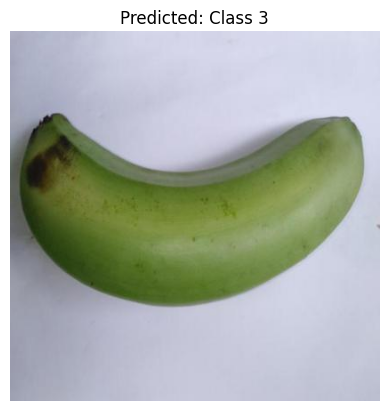

In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
# Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize ảnh về kích thước 32x32
    transforms.ToTensor(),       # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa giá trị pixel
])

# Tải ảnh chụp
image_path = "path.jpg"  # Đường dẫn tới ảnh của bạn
image = Image.open(image_path).convert("RGB")  # Mở ảnh và chuyển sang RGB
input_tensor = transform(image).unsqueeze(0)  # Thêm chiều batch

# Chạy suy luận
output = model(input_tensor)
predicted_class = torch.argmax(output, dim=1).item()

# Hiển thị ảnh và kết quả
class_labels = ["overripe", "ripe", "unripe"]  # Đổi tên lớp cho phù hợp với mô hình của bạn
plt.imshow(image)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis("off")
plt.show()

### Evaluating Model Performance on Test Dataset Using Confusion Matrix and Classification Report

**Description:**  
This script evaluates a trained PyTorch model's performance on a test dataset. The key functionalities include:

1. **Model Loading**:
   - Loads a pre-trained PyTorch model from a `.pth` file.
   - Sets the model to evaluation mode with `model.eval()`.

2. **Image Preprocessing**:
   - Resizes images to 32x32 pixels.
   - Converts images to tensors and normalizes pixel values for model compatibility.

3. **Dataset Prediction**:
   - Iterates over test dataset folders (organized by class names).
   - Predicts the class label for each image using the model and records the true and predicted labels.

4. **Confusion Matrix**:
   - Computes the confusion matrix to visualize classification performance across all classes.
   - Displays the matrix using a heatmap for better interpretability.

5. **Classification Report**:
   - Generates a detailed report including precision, recall, F1-score, and support for each class.


<ipython-input-13-0198a1d019f7>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/saved_model/simple_custom_model.pt

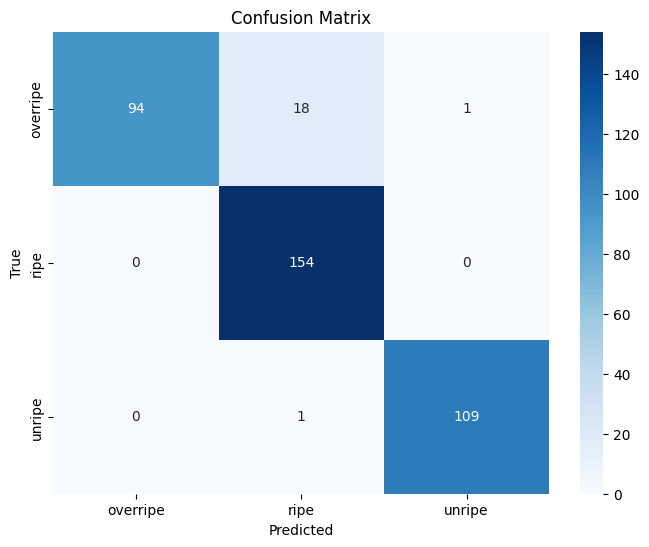

Classification Report:
               precision    recall  f1-score   support

    overripe       1.00      0.83      0.91       113
        ripe       0.89      1.00      0.94       154
      unripe       0.99      0.99      0.99       110

    accuracy                           0.95       377
   macro avg       0.96      0.94      0.95       377
weighted avg       0.95      0.95      0.95       377



In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Tải mô hình PyTorch
model = SimpleCustomModel()
model.load_state_dict(torch.load("/content/drive/MyDrive/saved_model/simple_custom_model.pth"))
model.eval()

# Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize ảnh về kích thước 32x32
    transforms.ToTensor(),       # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa giá trị pixel
])

# Tên lớp và bỏ qua lớp `rotten`
class_labels = ["overripe", "ripe", "unripe"]  # Đảm bảo các nhãn khớp với mô hình
test_folder = "/content/drive/MyDrive/Data/banana_classification/test"  # Thay bằng đường dẫn thư mục test

# Hàm dự đoán lớp của ảnh
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # Thêm chiều batch
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    return predicted_class

# Đọc dữ liệu và dự đoán
true_labels = []
predicted_labels = []

for label, class_name in enumerate(class_labels):
    class_folder = os.path.join(test_folder, class_name)
    if not os.path.isdir(class_folder):
        continue  # Bỏ qua nếu không phải thư mục

    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        if not img_file.lower().endswith((".png", ".jpg", ".jpeg")):
            continue  # Bỏ qua file không phải ảnh

        # Dự đoán lớp
        predicted_class = predict_image(img_path)
        true_labels.append(label)
        predicted_labels.append(predicted_class)

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# In báo cáo chi tiết
print("Classification Report:\n", report)


## Converting ONNX Model to TensorFlow SavedModel, TFLite, and C Header File

**Description:**  
This script showcases the end-to-end process of converting an ONNX model to TensorFlow's SavedModel format, then to TensorFlow Lite (TFLite) format, and finally generating a `.h` header file for embedded deployment.

#### Steps:

1. **ONNX to TensorFlow SavedModel**:
   - Loads an ONNX model using the `onnx` library.
   - Converts the ONNX model to TensorFlow SavedModel format using the `onnx-tf` library.

2. **TensorFlow SavedModel to TFLite**:
   - Uses TensorFlow's `TFLiteConverter` to convert the SavedModel to TFLite format.
   - Includes optimization options such as quantization to reduce model size and improve inference speed.

3. **TFLite Model Information**:
   - Loads the TFLite model using `tf.lite.Interpreter`.
   - Prints input and output tensor details for verification.

4. **TFLite to C Header File**:
   - Reads the binary data of the TFLite model.
   - Converts it to a C-style header file (`.h`) for deployment on embedded systems such as ESP32.

#### Outputs:
- **`saved_model_path`**: TensorFlow SavedModel directory.
- **`model.tflite`**: Converted TFLite model.
- **`model.h`**: C header file containing the TFLite model as a byte array.

This pipeline prepares the model for deployment on resource-constrained devices.

 ### Converted to TensorFlow SavedModel

In [ ]:
from onnx_tf.backend import prepare
import onnx

# Load mô hình ONNX
onnx_model = onnx.load("model.onnx")  # Đường dẫn đến file ONNX

# Chuyển đổi sang TensorFlow SavedModel
tf_rep = prepare(onnx_model)
tf_rep.export_graph("saved_model_path")  # Thư mục lưu SavedModel



### Converted to TensorFlow lite

In [6]:
import tensorflow as tf

# Tải mô hình SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_path")

# Tùy chọn lượng tử hóa (nếu cần)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Chuyển đổi sang TFLite
tflite_model = converter.convert()

# Lưu mô hình TFLite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


In [7]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Kiểm tra thông tin đầu vào và đầu ra
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)


Input details: [{'name': 'serving_default_input:0', 'index': 0, 'shape': array([ 1,  3, 32, 32], dtype=int32), 'shape_signature': array([ 1,  3, 32, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'PartitionedCall:0', 'index': 26, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([1, 3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


### Convert to Header file

In [8]:
# Chuyển đổi model.tflite thành file model.h
def convert_to_header(tflite_model_path, header_file_path):
    with open(tflite_model_path, 'rb') as tflite_file:
        tflite_data = tflite_file.read()

    with open(header_file_path, 'w') as header_file:
        header_file.write('#ifndef MODEL_H\n')
        header_file.write('#define MODEL_H\n\n')
        header_file.write(f'const unsigned char model_tflite[] = {{\n')

        for i, byte in enumerate(tflite_data):
            header_file.write(f'0x{byte:02x}, ')
            if (i + 1) % 12 == 0:
                header_file.write('\n')

        header_file.write('\n};\n\n')
        header_file.write(f'const unsigned int model_tflite_len = {len(tflite_data)};\n')
        header_file.write('#endif // MODEL_H\n')

# Đường dẫn tới file TFLite và file .h
convert_to_header('model.tflite', 'model.h')


#### Cách hoạt động của model.h
Chứa dữ liệu nhị phân của mô hình

File model.tflite (mô hình TensorFlow Lite) thực chất là một tệp nhị phân chứa các tham số và thông tin kiến trúc của mô hình.
File .h chuyển đổi dữ liệu nhị phân đó thành một mảng C (unsigned char) để nhúng trực tiếp vào mã nguồn C/C++.
Ví dụ:



const unsigned char model_tflite[] = {
    0x20, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
    ...
};

const unsigned int model_tflite_len = 123456;
model_tflite[]: Là mảng chứa toàn bộ nội dung của file .tflite.
model_tflite_len: Độ dài của mảng (tức là kích thước file .tflite).
Sử dụng trong mã nhúng

File model.h được bao gồm trong mã nguồn chính của bạn (bằng #include "model.h").
Trong chương trình, mảng model_tflite được sử dụng làm đầu vào cho TensorFlow Lite Micro Interpreter để chạy suy luận trên thiết bị.
